<hr>

https://www.tensorflow.org/datasets/catalog/fashion_mnist

https://github.com/zalandoresearch/fashion-mnist

Fashion-MNIST is a dataset of clothing images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

In [32]:
import numpy as np
import numpy.random as R
import matplotlib.pyplot as plt

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    from tensorflow.keras.datasets import fashion_mnist
    from tensorflow.keras import models
    from tensorflow.keras import layers
    from tensorflow.keras import optimizers
    from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

flabels = {0 : 't-shirt',
           1 : 'trousers',
           2 : 'pullover',
           3 : 'dress',
           4 : 'coat',
           5 : 'sandal',
           6 : 'shirt',
           7 : 'sneaker',
           8 : 'bag',
           9 : 'boot'}

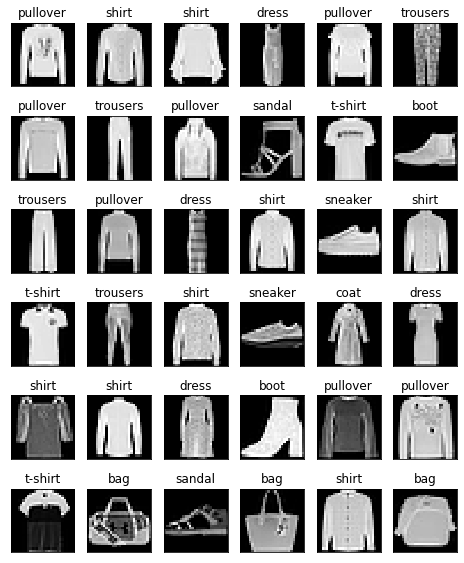

In [2]:
# display some images with their labels
fig = plt.figure(figsize=(8, 10))
N = 6
st_idx = R.randint(0, train_images.shape[0]-N*N-1)
for i in range(N*N):
    plt.subplot(N,N,i+1)
    plt.imshow(train_images[st_idx+i], cmap='gray', interpolation='none')
    plt.title(flabels[train_labels[st_idx+i]])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Q1a: Autoassociator

Note on Homework 7 that for the autoencoder (Q1a), you should use linear activation functions on the outputs (as a regression-type problem). For this, I've asked you to have it develop PCA-like representations, which means also using linear activation functions on the hidden layer. With a regression-type problem, mean_squared_error is an appropriate loss function

(I just realized that the autoencoder code I shared in Homework 1 used a nonlinear hidden layer, which is fine but not PCA-like, had sigmoidal output activations, which is ok since the pixel values are normalized to fall between 0 and 1, but had an inappropriate objective function - I think I copied that code from someplace at one time and hadn't bothered to check it closely since it was just a quick demo to make sure Keras/Tensorflow was working.)

In [3]:
def plot_model_loss(history):
    """Loss Plotting Function"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss As a Function of Number of Epochs Trained')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    
def plot_model_accuracy(history):
    """Accuracy Plotting Function"""
    plt.plot(history.history['acc'])
    plt.title('Model Accuracy As a Function of Number of Epochs Trained')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

In [4]:
# Reshape the training images to be a flattened 2D representation
new_dim = train_images.shape[1] * train_images.shape[2]
train_2D = np.reshape(train_images, (train_images.shape[0], new_dim))

# Expand the training labels to be 2D
train_labels = np.reshape(train_labels, (train_labels.shape[0], 1))

# Shuffle all vector (THE SAME ORDER)
shuffled_idx = R.permutation(train_2D.shape[0])
train_shuffled = train_2D[shuffled_idx,:]
train_labels_shuffled = train_labels[shuffled_idx,:]

# Take half of the above for the training data for Q1a
train_half = train_shuffled[0:train_shuffled.shape[0]//2]
train_labels_half = train_labels_shuffled[0:train_shuffled.shape[0]//2]

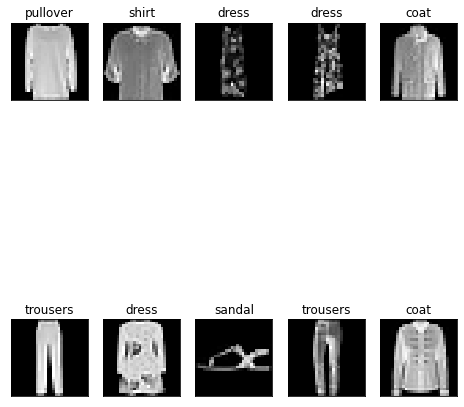

In [5]:
train_imagesREMAKE_shuffled = np.reshape(train_shuffled, (train_shuffled.shape[0],28,28))

# display some images with their labels
fig = plt.figure(figsize=(8, 10))
N = 6
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(train_imagesREMAKE_shuffled[i], cmap='gray', interpolation='none')
    plt.title(flabels[train_labels_shuffled[i][0]])
    plt.xticks([])
    plt.yticks([])
plt.show()

# Automated Attempts

In [6]:
def generate_aa(encoding_dim, act1, act2, loss_func, train_half, train_half_labels, my_epochs=20, my_batch=256):
    # this is our input placeholder
    input_img = layers.Input(shape=(new_dim,))
    # "encoded" is the encoded representation of the input
    encoded = layers.Dense(encoding_dim, activation=act1)(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Dense(new_dim, activation=act2)(encoded)

    # this model maps an input to its reconstruction
    autoencoder = models.Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = models.Model(input_img, encoded)

    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = layers.Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = models.Model(encoded_input, decoder_layer(encoded_input))

    # compile model
    autoencoder.compile(optimizer='adam', loss=loss_func, metrics=['accuracy'])

    print(train_half.shape)
    print(train_labels_half.shape)

    # My code here
    x_train = train_half[0:int(train_half.shape[0]*0.8), :]
    x_test = train_half[int(train_labels_half.shape[0]*0.8):, :]

    x_train = x_train / np.amax(train_half)
    x_test = x_test / np.amax(train_half)

    print(x_train.shape)
    print(x_test.shape)

    history = autoencoder.fit(x_train, x_train,
                    epochs=my_epochs,
                    batch_size=my_batch,
                    verbose = False,
                    shuffle=True,
                    validation_data=(x_test, x_test))

    plot_model_loss(history)
    plot_model_accuracy(history)
    
    return autoencoder, history

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
(30000, 784)
(30000, 1)
(24000, 784)
(6000, 784)


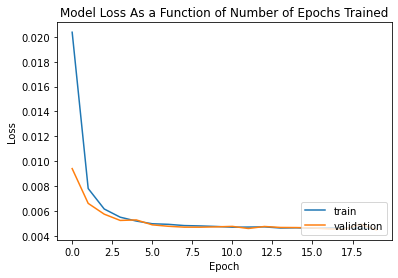

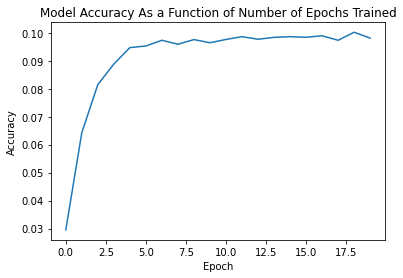

In [7]:
encoding_dim = 200
aa200, aahistory = generate_aa(encoding_dim, 'linear', 'linear', 'mean_squared_error', train_half, train_labels_half, my_batch=30)

## Q1b
> Use the remaining half of the original set as inputs to train a densely connected multilayer NN that learns, via backpropagation to classify the images.
1. Pick the proper activiation functions n the hidden units
2. Pick the proper activation function on the output units for a classificaiotn network
3. Make sure you also pick a proper loss function for a classification network

--> Multiclass classification: Relu, softmax, categorical_cross_entropy

In [8]:
def create_network(node_list=[2,2,1], func_list=['relu'], my_opt='adam', loss_func='categorical_crossentropy'):
    network = models.Sequential()
        
    for idx, arg in enumerate(node_list):
        if idx == 0:
            n_prev = arg
        elif idx == len(node_list)-1:
            my_func = 'softmax'
            network.add(layers.Dense(arg, 
                             activation=my_func, 
                             input_shape=(n_prev,)))
        else:
            network.add(layers.Dense(arg, 
                                     activation=func_list[0], 
                                     input_shape=(n_prev,)))
    
    # configure optimizer
    # sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9)
    network.compile(optimizer=my_opt, 
                    loss=loss_func, 
                    metrics=['accuracy', 'mse'])
    
    return network

In [9]:
def run_pipeline(train_array, train_labels, test_dim, test_pats=None, test_labels=None, num_epochs=30, my_batch=30):
    best_acc = -1
    best_val_acc = -1
    
    input_dim = train_array.shape[1]
    
    for _ in range(5):
        network = create_network(test_dim, input_dim)
        
        history = network.fit(train_array, 
                              train_labels, 
                              verbose=False, 
                              validation_split=.2, 
                              epochs=num_epochs, 
                              batch_size=my_batch)
        print('Done training!')
        
        # Determine if this model was better than the previous ones
        new_acc = history.history['acc'][-1]
        new_val_acc = history.history['val_acc'][-1]
        if new_acc > best_acc and new_val_acc > best_val_acc:
            best_acc = new_acc
            best_val_acc = new_val_acc
            best_history = history
            best_network = network
        # Show the accuracy plot each time
        # plot_model_acc(history)

    # Show the accuracy of the best plot
    plot_model_acc(best_history)
    
    '''
    out = best_network.predict(
       test_pats, 
       batch_size = my_batch, 
       verbose = 0,  
       workers = 1, 
       use_multiprocessing = False)
    
    results = best_network.evaluate(test_pats, 
                           test_labels_onehot_2D, 
                           verbose=False)

    test_loss = results[0]
    test_acc = results[1]

    print('test_loss (MSE)     : {}'.format(test_loss))
    print('test_acc (%Correct) : {}'.format(test_acc))
    '''
    
    return best_network, best_history #, out, results

In [10]:
train_half2 = train_shuffled[train_shuffled.shape[0]//2:]
train_labels_half2 = train_labels_shuffled[train_shuffled.shape[0]//2:]

print(train_half2.shape)
print(train_labels_half2.shape)

(30000, 784)
(30000, 1)


# From the man himself:
> Instead of "fixing these weights" just use the weights and biases to calculate the activations, which will then be used as inputs to a trained network

In [11]:
aanetwork = aa200
aanetwork.summary()

aaW = aanetwork.layers[1].get_weights()[0]
aab = aanetwork.layers[1].get_weights()[1]

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 200)               157000    
_________________________________________________________________
dense_1 (Dense)              (None, 784)               157584    
Total params: 314,584
Trainable params: 314,584
Non-trainable params: 0
_________________________________________________________________


In [17]:
backprop_network = create_network(node_list=[new_dim,encoding_dim,30,20,10])
backprop_network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 200)               157000    
_________________________________________________________________
dense_7 (Dense)              (None, 30)                6030      
_________________________________________________________________
dense_8 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                210       
Total params: 163,860
Trainable params: 163,860
Non-trainable params: 0
_________________________________________________________________


In [18]:
def apply_weights(aaW, aab, inputs):
    inputs = np.matmul(inputs, aaW) + aab
    #"Relu" implementation for activations
    x = np.maximum(inputs, 0)
    return x

In [40]:
print(aaW.shape)
print(aab.shape)
print(train_half.shape)

(784, 200)
(200,)
(30000, 784)


In [20]:
# y = mx + b
# fixed_inputs = W * original_inputs + b

fixed_input = apply_weights(aaW, aab, train_half)
print(fixed_input.shape)

(30000, 200)


In [22]:
backprop_network.layers[1].set_weights((aaW, aab))

ValueError: Layer weight shape (200, 30) not compatible with provided weight shape (784, 200)

In [ ]:
my_epochs=20
my_batch=256

history2 = network.fit(train_half2, 
                              train_labels_half2, 
                              verbose=False, 
                              validation_split=.2, 
                              epochs=num_epochs, 
                              batch_size=my_batch)

## Q2: Use a CNN to Classify the Fashion MNIST

In [ ]:
# padding='valid'
# ^This is the default. It stays inside the previous layer
# 'same' --> Goes outside previous layer --> This is what we "may want to use"

# strides=(1,1)
# ^(default) convolution full covers previous layer
# Usually use full stride
# strides=(2,2) has gaps

In [24]:
network = models.Sequential()

# first convolution layer parameters
num_fm_1 = 16
conv_dim = 3
input_sz = 28
# second convolution layer parameters
num_fm_2 = 16
# max pooling parameters
mp_dim = 2
nout = 10

# first convolution layer
network.add(layers.Conv2D(num_fm_1, (conv_dim, conv_dim), 
                          activation='relu', 
                          input_shape=(input_sz, input_sz, 1)))
# second convolution layer
network.add(layers.Conv2D(num_fm_2, (conv_dim, conv_dim)))
# max pooling
network.add(layers.MaxPooling2D(mp_dim, mp_dim))

network.add(layers.Conv2D(16, (3,3), activation='relu'))
network.add(layers.MaxPooling2D((2,2)))
network.add(layers.Flatten())
network.add(layers.Dense(20, activation='relu'))
network.add(layers.Dense(nout, activation='softmax'))


for layer in network.layers:
    print('layer name: {} | input shape: {} | output shape: {}'.
          format(layer.name, layer.input.shape, layer.output.shape))

layer name: conv2d | input shape: (?, 28, 28, 1) | output shape: (?, 26, 26, 16)
layer name: conv2d_1 | input shape: (?, 26, 26, 16) | output shape: (?, 24, 24, 16)
layer name: max_pooling2d | input shape: (?, 24, 24, 16) | output shape: (?, 12, 12, 16)
layer name: conv2d_2 | input shape: (?, 12, 12, 16) | output shape: (?, 10, 10, 16)
layer name: max_pooling2d_1 | input shape: (?, 10, 10, 16) | output shape: (?, 5, 5, 16)
layer name: flatten | input shape: (?, 5, 5, 16) | output shape: (?, 400)
layer name: dense_10 | input shape: (?, 400) | output shape: (?, 20)
layer name: dense_11 | input shape: (?, 20) | output shape: (?, 10)


In [27]:
train_imagesRE = train_images.reshape(train_images.shape[0], input_sz, input_sz, 1)
test_imagesRE = test_images.reshape(test_images.shape[0], input_sz, input_sz, 1)

In [28]:
network.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])

Think I need to rework the train and test labels to be full matrices (e.g. (inputs, num_classes) ) since I am using softmax which should return a percentage for each

In [34]:

# check out dimensions and types of mnist data
print('Training labels shape: ', train_labels.shape)
print('Training labels type:  ', type(train_labels[0]))
print()

# check out what the first 9 labels look like
print("First 9 training labels as labels:\n", train_labels[:9])
print()

# need to categorically encode the labels as "one hot"
train_labelsRE = to_categorical(train_labels)
test_labelsRE = to_categorical(test_labels)

print("First 9 training labels as one-hot encoded vectors:\n", train_labelsRE[:9])

Training labels shape:  (60000,)
Training labels type:   <class 'numpy.uint8'>

First 9 training labels as labels:
 [9 0 0 3 0 2 7 2 5]

First 9 training labels as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [36]:
history = network.fit(train_imagesRE, train_labelsRE, verbose=True,
                      validation_split=.2, epochs=20, batch_size=256)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 27s 556us/sample - loss: 0.9647 - acc: 0.6795 - val_loss: 0.8421 - val_acc: 0.7188
Epoch 2/20
48000/48000 [==============================] - 27s 562us/sample - loss: 0.6791 - acc: 0.7559 - val_loss: 0.5714 - val_acc: 0.7931
Epoch 3/20
48000/48000 [==============================] - 27s 570us/sample - loss: 0.5175 - acc: 0.8104 - val_loss: 0.4970 - val_acc: 0.8177
Epoch 4/20
48000/48000 [==============================] - 28s 573us/sample - loss: 0.4482 - acc: 0.8353 - val_loss: 0.4560 - val_acc: 0.8317
Epoch 5/20
48000/48000 [==============================] - 27s 572us/sample - loss: 0.4099 - acc: 0.8470 - val_loss: 0.4185 - val_acc: 0.8460
Epoch 6/20
48000/48000 [==============================] - 30s 623us/sample - loss: 0.3848 - acc: 0.8570 - val_loss: 0.4071 - val_acc: 0.8543
Epoch 7/20
48000/48000 [==============================] - 32s 661us/sample - loss: 0.3619 - acc: 0.8649 

In [37]:
test_loss, test_accuracy = network.evaluate(test_imagesRE, test_labelsRE)

10000/10000 [==============================] - 3s 300us/sample - loss: 0.3576 - acc: 0.8799


In [39]:
print('test_acc:', test_accuracy)

test_acc: 0.8799
